In [57]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')

symbols_list = sp500['Symbol'].unique().tolist()

end_date = '2023-09-27'

start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)

df = yf.download(tickers=symbols_list,
                 start=start_date,
                 end=end_date).stack()

df.index.names = ['date', 'ticker']

df.columns = df.columns.str.lower()

df

[*********************100%%**********************]  503 of 503 completed

3 Failed downloads:
['GEV', 'VLTO', 'SOLV']: YFChartError("%ticker%: Data doesn't exist for startDate = 1443499200, endDate = 1695787200")


Price               adj close       close        high         low        open  \
date       ticker                                                               
2015-09-29 A        31.483553   33.740002   34.060001   33.240002   33.360001   
           AAL      37.361622   39.180000   39.770000   38.790001   39.049999   
           AAPL     24.651138   27.264999   28.377501   26.965000   28.207500   
           ABBV     36.334900   52.790001   54.189999   51.880001   53.099998   
           ABT      33.478706   39.500000   40.150002   39.029999   39.259998   
...                       ...         ...         ...         ...         ...   
2023-09-26 XYL      88.736298   89.519997   90.849998   89.500000   90.379997   
           YUM     122.211014  124.010002  124.739998  123.449997  124.239998   
           ZBH     111.782722  112.459999  117.110001  112.419998  116.769997   
           ZBRA    223.960007  223.960007  226.649994  222.580002  225.970001   
           ZTS     175.547699  176.869995  178.449997  176.270004  176.580002   

Price                   volume  
date       ticker               
2015-09-29 A         2252400.0  
           AAL       7478800.0  
           AAPL    293461600.0  
           ABBV     12842800.0  
           ABT      12287500.0  
...                        ...  
2023-09-26 XYL       1322400.0  
           YUM       1500600.0  
           ZBH       3610500.0  
           ZBRA       355400.0  
           ZTS       1463200.0  

[988898 rows x 6 columns]

In [58]:

df.shape

(988898, 6)

In [59]:
df = df.interpolate(method='linear')

In [60]:
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
                                                          
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
                                                          
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

df['dollar_volume'] = (df['adj close']*df['volume'])/1e6

df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2015-09-29 A        31.483553   33.740002   34.060001   33.240002   33.360001   
           AAL      37.361622   39.180000   39.770000   38.790001   39.049999   
           AAPL     24.651138   27.264999   28.377501   26.965000   28.207500   
           ABBV     36.334900   52.790001   54.189999   51.880001   53.099998   
           ABT      33.478706   39.500000   40.150002   39.029999   39.259998   
...                       ...         ...         ...         ...         ...   
2023-09-26 XYL      88.736298   89.519997   90.849998   89.500000   90.379997   
           YUM     122.211014  124.010002  124.739998  123.449997  124.239998   
           ZBH     111.782722  112.459999  117.110001  112.419998  116.769997   
           ZBRA    223.960007  223.960007  226.649994  222.580002  225.970001   
           ZTS     175.547699  176.869995  178.449997  176.270004  176.580002   

Price                   volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2015-09-29 A         2252400.0         -0.000998        NaN       NaN   
           AAL       7478800.0         -0.000443        NaN       NaN   
           AAPL    293461600.0         -0.005712        NaN       NaN   
           ABBV     12842800.0         -0.054655        NaN       NaN   
           ABT      12287500.0         -0.009402        NaN       NaN   
...                        ...               ...        ...       ...   
2023-09-26 XYL       1322400.0         -0.000018  26.146746  4.485761   
           YUM       1500600.0         -0.000051  36.057165  4.811707   
           ZBH       3610500.0          0.000099  31.893258  4.748085   
           ZBRA       355400.0          0.000133  29.494977  5.400991   
           ZTS       1463200.0          0.000062  42.623464  5.156108   

Price                bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2015-09-29 A            NaN       NaN       NaN       NaN      70.913555  
           AAL          NaN       NaN       NaN       NaN     279.420098  
           AAPL         NaN       NaN       NaN       NaN    7234.162489  
           ABBV         NaN       NaN       NaN       NaN     466.641852  
           ABT          NaN       NaN       NaN       NaN     411.369604  
...                     ...       ...       ...       ...            ...  
2023-09-26 XYL     4.567684  4.649607  0.033800 -2.159189     117.344880  
           YUM     4.841672  4.871637  0.142547 -1.363695     183.389847  
           ZBH     4.787752  4.827420 -0.381708 -0.881067     403.591519  
           ZBRA    5.539167  5.677342 -0.057389 -1.600791      79.595386  
           ZTS     5.214922  5.273735  0.651515 -1.188278     256.861393  

[988898 rows x 14 columns]

In [61]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open',
                                                          'high', 'low', 'close']]

data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                   df.unstack()[last_cols].resample('M').last().stack('ticker')],
                  axis=1)).dropna()

data

dollar_volume   adj close  garman_klass_vol        rsi  \
date       ticker                                                           
2015-11-30 A          135.992838   39.023182         -0.001992  73.421390   
           AAL        287.915812   39.429935         -0.000966  40.718989   
           AAPL      4023.983980   26.854136         -0.003307  55.537328   
           ABBV       337.563929   40.393524         -0.059549  49.376842   
           ABT        211.659044   38.293568         -0.011216  56.962539   
...                          ...         ...               ...        ...   
2023-09-30 OTIS       154.361755   78.356499         -0.000097  33.116229   
           ABNB      1633.500725  132.279999          0.000213  44.494127   
           CEG        196.670368  107.862022          0.000131  55.245468   
           GEHC       212.275851   66.130219          0.000185  40.922335   
           KVUE       670.804304   20.006193         -0.000159  35.706314   

                     bb_low    bb_mid   bb_high       atr      macd  
date       ticker                                                    
2015-11-30 A       3.545992  3.618440  3.690888 -1.033887  0.567157  
           AAL     3.672028  3.749832  3.827636  0.190822 -0.418771  
           AAPL    3.281679  3.324991  3.368302 -0.967900 -0.142790  
           ABBV    3.726694  3.774943  3.823191 -0.526809  0.145676  
           ABT     3.656055  3.677909  3.699763 -1.064842  0.335559  
...                     ...       ...       ...       ...       ...  
2023-09-30 OTIS    4.370137  4.415425  4.460712 -1.028320 -1.534536  
           ABNB    4.857047  4.940924  5.024801 -1.006939 -0.037854  
           CEG     4.652147  4.692320  4.732493 -0.436215  0.366876  
           GEHC    4.155436  4.212972  4.270508 -0.893478 -1.116463  
           KVUE    3.014275  3.089221  3.164168 -0.899746 -1.435621  

[46692 rows x 9 columns]

In [62]:

data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))

data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2016-10-31 AAL      39.134331         -0.000176  62.203554  3.604673   
           AAPL     26.212471         -0.002468  49.891032  3.294237   
           ABBV     40.245125         -0.046691  27.477693  3.753446   
           ABT      34.293465         -0.007492  38.008939  3.554632   
           ACN     103.569626         -0.004643  53.823650  4.637342   
...                       ...               ...        ...       ...   
2023-09-30 WMT      53.597538         -0.000041  54.722524  3.984976   
           XOM     113.372101         -0.000065  59.440184  4.687091   
           MRNA     98.120003          0.000146  38.747314  4.582514   
           UBER     44.270000          0.000441  45.005268  3.806654   
           ABNB    132.279999          0.000213  44.494127  4.857047   

                     bb_mid   bb_high       atr      macd  
date       ticker                                          
2016-10-31 AAL     3.655494  3.706314  0.402199  1.131596  
           AAPL    3.323117  3.351997 -1.038688 -0.195978  
           ABBV    3.807610  3.861774 -0.893132 -0.760594  
           ABT     3.605106  3.655580 -1.035224 -0.650888  
           ACN     4.648980  4.660617 -0.996806 -0.135456  
...                     ...       ...       ...       ...  
2023-09-30 WMT     4.002446  4.019915 -0.196381  0.399459  
           XOM     4.727187  4.767283  0.601335  1.400624  
           MRNA    4.685332  4.788149 -0.529511 -0.376899  
           UBER    3.862227  3.917801 -0.746098 -0.133973  
           ABNB    4.940924  5.024801 -1.006939 -0.037854  

[12516 rows x 8 columns]

In [63]:
def calculate_returns(df):

    outlier_cutoff = 0.005

    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:

        df[f'return_{lag}m'] = (df['adj close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df
    
    
data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2017-10-31 AAL      45.534161         -0.000363  41.051765  3.849110   
           AAPL     39.713902         -0.001055  69.196783  3.594730   
           ABBV     67.491150         -0.034008  55.247889  4.196702   
           ABT      48.493378         -0.005190  53.844904  3.892568   
           ACN     129.399689         -0.003925  69.365133  4.802675   
...                       ...               ...        ...       ...   
2023-09-30 WMT      53.597538         -0.000041  54.722524  3.984976   
           XOM     113.372101         -0.000065  59.440184  4.687091   
           MRNA     98.120003          0.000146  38.747314  4.582514   
           UBER     44.270000          0.000441  45.005268  3.806654   
           ABNB    132.279999          0.000213  44.494127  4.857047   

                     bb_mid   bb_high       atr      macd  return_1m  \
date       ticker                                                      
2017-10-31 AAL     3.921750  3.994389  1.011062 -0.018698  -0.014108   
           AAPL    3.641603  3.688475 -0.906642 -0.039275   0.096808   
           ABBV    4.243063  4.289423  0.375557  0.473815   0.022728   
           ABT     3.916137  3.939707 -1.040044  0.276132   0.021276   
           ACN     4.842354  4.882034 -0.986514  0.352341   0.064180   
...                     ...       ...       ...       ...        ...   
2023-09-30 WMT     4.002446  4.019915 -0.196381  0.399459  -0.000676   
           XOM     4.727187  4.767283  0.601335  1.400624   0.046947   
           MRNA    4.685332  4.788149 -0.529511 -0.376899  -0.132219   
           UBER    3.862227  3.917801 -0.746098 -0.133973  -0.062672   
           ABNB    4.940924  5.024801 -1.006939 -0.037854   0.005549   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2017-10-31 AAL      0.022981  -0.023860   0.016495   0.007008    0.012702  
           AAPL     0.015250   0.044955   0.028875   0.038941    0.035228  
           ABBV     0.098590   0.091379   0.056495   0.047273    0.044026  
           ABT      0.034308   0.034801   0.038672   0.031320    0.029294  
           ACN      0.048454   0.037202   0.028692   0.027398    0.018728  
...                      ...        ...        ...        ...         ...  
2023-09-30 WMT      0.010014   0.012354   0.017574   0.016553    0.020256  
           XOM      0.046139   0.030496   0.012838   0.008747    0.027037  
           MRNA    -0.086803  -0.068763  -0.071952  -0.064976   -0.015431  
           UBER    -0.053920   0.008422   0.057244   0.066838    0.043691  
           ABNB    -0.067704   0.010603   0.010289   0.049124    0.019401  

[10346 rows x 14 columns]

In [62]:
data.head()

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2017-10-31 AAL      45.534164         -0.000363  41.051777  3.849110   
           AAPL     39.713902         -0.001055  69.196642  3.594730   
           ABBV     67.491158         -0.034008  55.247873  4.196702   
           ABT      48.493366         -0.005190  53.844838  3.892568   
           ACN     129.399719         -0.003925  69.365171  4.802675   

                     bb_mid   bb_high       atr      macd  return_1m  \
date       ticker                                                      
2017-10-31 AAL     3.921750  3.994389  1.011062 -0.018698  -0.014108   
           AAPL    3.641603  3.688475 -0.906642 -0.039275   0.096808   
           ABBV    4.243063  4.289423  0.375557  0.473813   0.022728   
           ABT     3.916137  3.939707 -1.040044  0.276131   0.021275   
           ACN     4.842354  4.882034 -0.986514  0.352342   0.064180   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2017-10-31 AAL      0.022981  -0.023860   0.016495   0.007008    0.012702  
           AAPL     0.015250   0.044955   0.028875   0.038941    0.035228  
           ABBV     0.098590   0.091379   0.056495   0.047273    0.044026  
           ABT      0.034308   0.034801   0.038672   0.031320    0.029294  
           ACN      0.048454   0.037203   0.028692   0.027398    0.018728

In [64]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                               'famafrench',
                               start='2010')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'

factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2017-10-31 AAL     0.0225 -0.0194  0.0020  0.0093 -0.0325  -0.014108
           AAPL    0.0225 -0.0194  0.0020  0.0093 -0.0325   0.096808
           ABBV    0.0225 -0.0194  0.0020  0.0093 -0.0325   0.022728
           ABT     0.0225 -0.0194  0.0020  0.0093 -0.0325   0.021276
           ACN     0.0225 -0.0194  0.0020  0.0093 -0.0325   0.064180
...                   ...     ...     ...     ...     ...        ...
2023-09-30 VRTX   -0.0524 -0.0180  0.0152  0.0186 -0.0083   0.009617
           VZ     -0.0524 -0.0180  0.0152  0.0186 -0.0083  -0.056890
           WFC    -0.0524 -0.0180  0.0152  0.0186 -0.0083  -0.015500
           WMT    -0.0524 -0.0180  0.0152  0.0186 -0.0083  -0.000676
           XOM    -0.0524 -0.0180  0.0152  0.0186 -0.0083   0.046947

[10346 rows x 6 columns]

In [65]:
observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2017-10-31 AAL     0.0225 -0.0194  0.0020  0.0093 -0.0325  -0.014108
           AAPL    0.0225 -0.0194  0.0020  0.0093 -0.0325   0.096808
           ABBV    0.0225 -0.0194  0.0020  0.0093 -0.0325   0.022728
           ABT     0.0225 -0.0194  0.0020  0.0093 -0.0325   0.021276
           ACN     0.0225 -0.0194  0.0020  0.0093 -0.0325   0.064180
...                   ...     ...     ...     ...     ...        ...
2023-09-30 VRTX   -0.0524 -0.0180  0.0152  0.0186 -0.0083   0.009617
           VZ     -0.0524 -0.0180  0.0152  0.0186 -0.0083  -0.056890
           WFC    -0.0524 -0.0180  0.0152  0.0186 -0.0083  -0.015500
           WMT    -0.0524 -0.0180  0.0152  0.0186 -0.0083  -0.000676
           XOM    -0.0524 -0.0180  0.0152  0.0186 -0.0083   0.046947

[10316 rows x 6 columns]

In [66]:
betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'], 
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

betas

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2017-10-31 AAL          NaN       NaN       NaN       NaN       NaN
           AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2023-09-30 VRTX    0.456426 -0.445902 -0.312668 -0.079430  0.800286
           VZ      0.332655 -0.165645  0.267344  0.310367  0.106903
           WFC     1.121747  0.300521  2.061532 -0.439490 -1.517556
           WMT     0.700556 -0.315600 -0.413433 -0.142905  0.508471
           XOM     0.983510 -1.093760  1.756777 -0.640866 -0.368456

[10316 rows x 5 columns]

In [67]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = (data.join(betas.groupby('ticker').shift()))

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis=1)

data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10111 entries, (Timestamp('2017-10-31 00:00:00'), 'AAL') to (Timestamp('2023-09-30 00:00:00'), 'UBER')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   garman_klass_vol  10111 non-null  float64
 1   rsi               10111 non-null  float64
 2   bb_low            10111 non-null  float64
 3   bb_mid            10111 non-null  float64
 4   bb_high           10111 non-null  float64
 5   atr               10111 non-null  float64
 6   macd              10111 non-null  float64
 7   return_1m         10111 non-null  float64
 8   return_2m         10111 non-null  float64
 9   return_3m         10111 non-null  float64
 10  return_6m         10111 non-null  float64
 11  return_9m         10111 non-null  float64
 12  return_12m        10111 non-null  float64
 13  Mkt-RF            10111 non-null  float64
 14  SMB               10111 non-null  float64
 15  HML       

In [21]:
data.head()

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2017-10-31 AAL      45.534164         -0.000363  41.051768  3.849110   
           AAPL     39.713905         -0.001055  69.196778  3.594730   
           ABBV     67.491158         -0.034008  55.247890  4.196702   
           ABT      48.493378         -0.005190  53.844927  3.892568   
           ACN     129.399719         -0.003925  69.365305  4.802675   

                     bb_mid   bb_high       atr      macd  return_1m  \
date       ticker                                                      
2017-10-31 AAL     3.921750  3.994389  1.011062 -0.018698  -0.014108   
           AAPL    3.641603  3.688475 -0.906642 -0.039276   0.096808   
           ABBV    4.243063  4.289423  0.375557  0.473815   0.022728   
           ABT     3.916137  3.939707 -1.040044  0.276133   0.021276   
           ACN     4.842354  4.882034 -0.986514  0.352342   0.064180   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2017-10-31 AAL      0.022981  -0.023860   0.016495   0.007008    0.012702  
           AAPL     0.015250   0.044955   0.028875   0.038941    0.035228  
           ABBV     0.098590   0.091379   0.056495   0.047273    0.044026  
           ABT      0.034308   0.034801   0.038672   0.031320    0.029294  
           ACN      0.048455   0.037202   0.028692   0.027398    0.018728

In [115]:
pip install --upgrade scikit-learn threadpoolctl


     ---------------------------------------- 11.0/11.0 MB 3.8 MB/s eta 0:00:00
  Attempting uninstall: threadpoolctl
    Found existing installation: threadpoolctl 2.2.0
    Uninstalling threadpoolctl-2.2.0:
      Successfully uninstalled threadpoolctl-2.2.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.4.1.post1
    Uninstalling scikit-learn-1.4.1.post1:
      Successfully uninstalled scikit-learn-1.4.1.post1
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\ASUS\\anaconda3\\Lib\\site-packages\\~klearn\\.libs\\msvcp140.dll'
Consider using the `--user` option or check the permissions.



In [78]:
from sklearn.cluster import KMeans

data = data.drop('cluster', axis=1)

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init=initial_centroids).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2017-10-31 AAL            -0.000363  41.051765  3.849110  3.921750  3.994389   
           AAPL           -0.001055  69.196783  3.594730  3.641603  3.688475   
           ABBV           -0.034008  55.247889  4.196702  4.243063  4.289423   
           ABT            -0.005190  53.844904  3.892568  3.916137  3.939707   
           ACN            -0.003925  69.365133  4.802675  4.842354  4.882034   
...                             ...        ...       ...       ...       ...   
2023-09-30 WFC            -0.000110  40.920273  3.697054  3.737418  3.777782   
           WMT            -0.000041  54.722524  3.984976  4.002446  4.019915   
           XOM            -0.000065  59.440184  4.687091  4.727187  4.767283   
           MRNA            0.000146  38.747314  4.582514  4.685332  4.788149   
           UBER            0.000441  45.005268  3.806654  3.862227  3.917801   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2017-10-31 AAL     1.011062 -0.018698  -0.014108   0.022981  -0.023860   
           AAPL   -0.906642 -0.039275   0.096808   0.015250   0.044955   
           ABBV    0.375557  0.473815   0.022728   0.098590   0.091379   
           ABT    -1.040044  0.276132   0.021276   0.034308   0.034801   
           ACN    -0.986514  0.352341   0.064180   0.048454   0.037202   
...                     ...       ...        ...        ...        ...   
2023-09-30 WFC    -0.558742 -0.282326  -0.015500  -0.057917  -0.013554   
           WMT    -0.196381  0.399459  -0.000676   0.010014   0.012354   
           XOM     0.601335  1.400624   0.046947   0.046139   0.030496   
           MRNA   -0.529511 -0.376899  -0.132219  -0.086803  -0.068763   
           UBER   -0.746098 -0.133973  -0.062672  -0.053920   0.008422   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2017-10-31 AAL      0.016495   0.007008    0.012702  1.265664  1.314316   
           AAPL     0.028875   0.038941    0.035228  1.275750 -0.271695   
           ABBV     0.056495   0.047273    0.044026  0.494522  0.362281   
           ABT      0.038672   0.031320    0.029294  0.828091 -0.199021   
           ACN      0.028692   0.027398    0.018728  1.199048 -0.166703   
...                      ...        ...         ...       ...       ...   
2023-09-30 WFC      0.016712   0.000702    0.003255  1.137640  0.314482   
           WMT      0.017574   0.016553    0.020256  0.740054 -0.261890   
           XOM      0.012838   0.008747    0.027037  1.005968 -1.051371   
           MRNA    -0.071952  -0.064976   -0.015431  1.155154  0.762525   
           UBER     0.057244   0.066838    0.043691  1.078922  1.162540   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2017-10-31 AAL     0.601340  0.458859  0.563294        0  
           AAPL   -0.591145  0.647781  0.458078        2  
           ABBV   -0.033102  0.241981  0.164922        3  
           ABT    -0.529384  0.252405  0.970212        3  
           ACN    -0.328213  0.267785  0.168881        2  
...                     ...       ...       ...      ...  
2023-09-30 WFC     2.009074 -0.404338 -1.468839        3  
           WMT    -0.522678 -0.126425  0.642627        1  
           XOM     1.707835 -0.675679 -0.284026        1  
           MRNA   -1.165677  0.590306  0.993548        3  
           UBER   -0.257003 -1.482231 -0.450323        2  

[10111 rows x 19 columns]

In [75]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,0] , cluster_0.iloc[:,6] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,0] , cluster_1.iloc[:,6] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,0] , cluster_2.iloc[:,6] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,0] , cluster_3.iloc[:,6] , color = 'black', label='cluster 3')
    
    plt.legend()
    plt.show()
    return

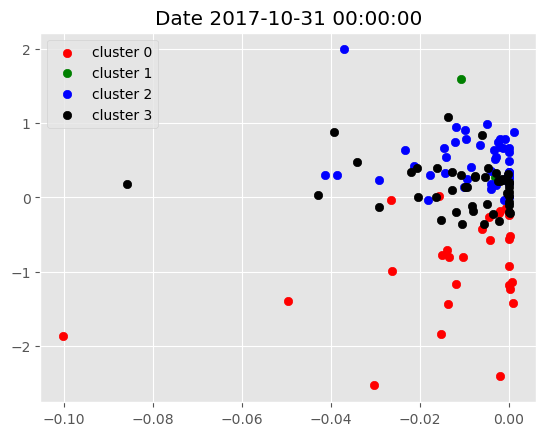

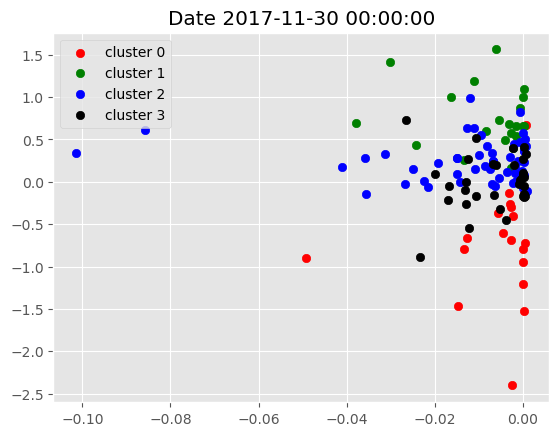

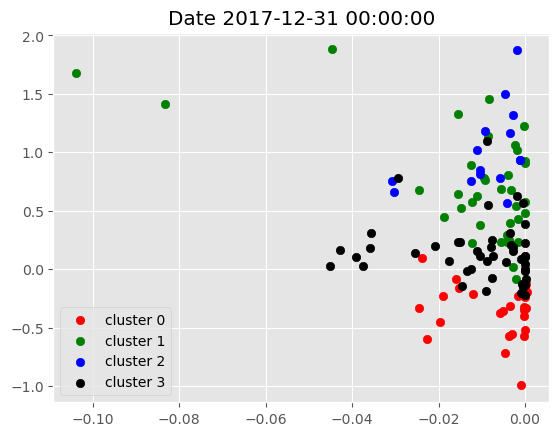

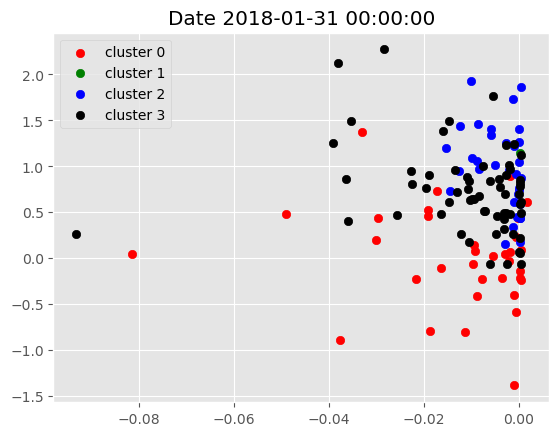

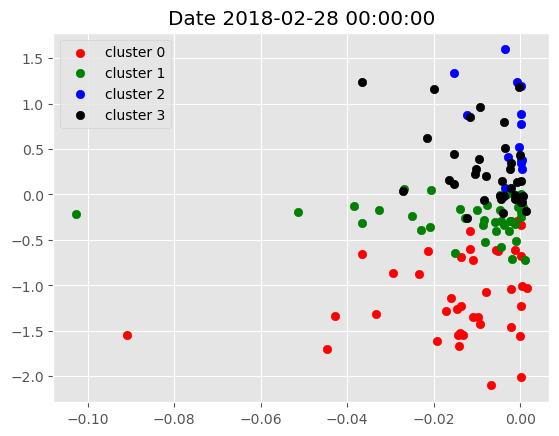

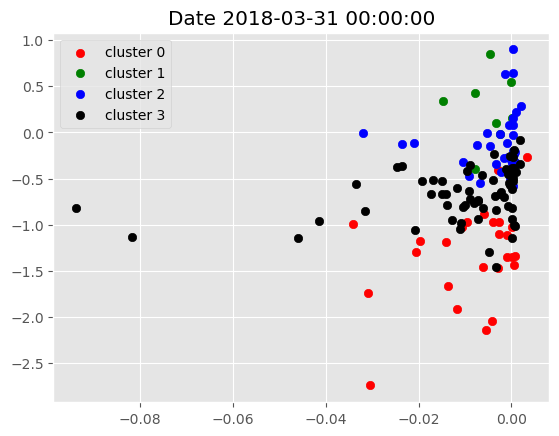

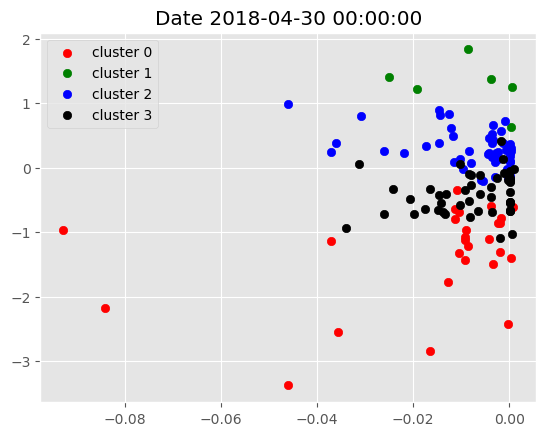

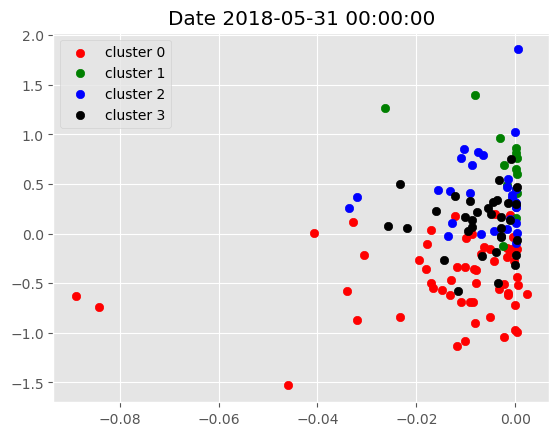

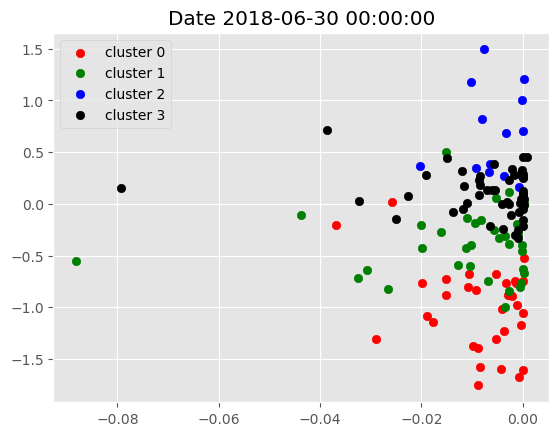

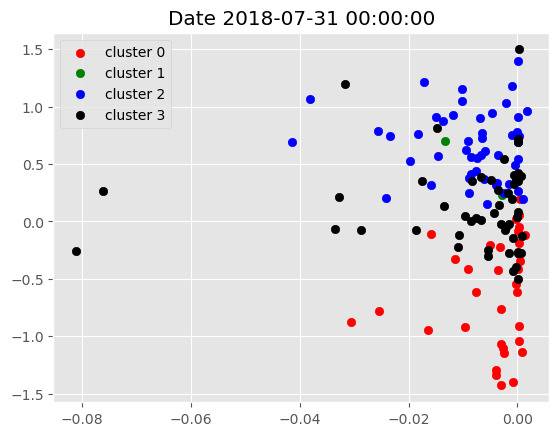

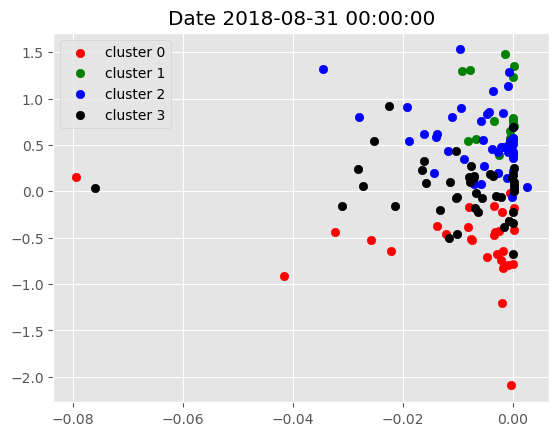

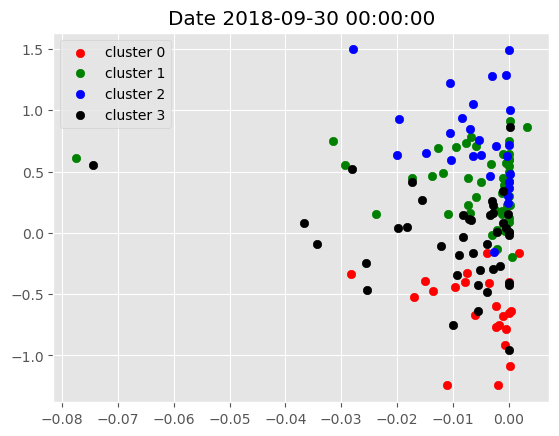

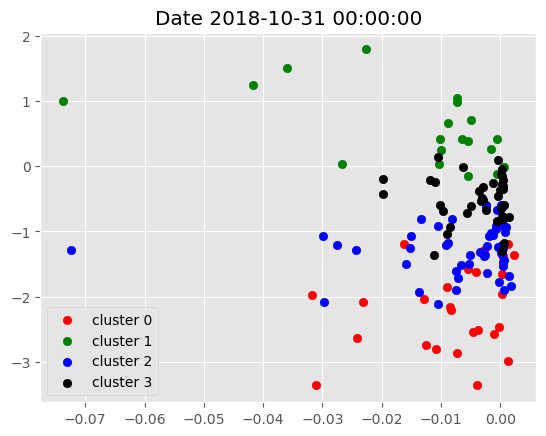

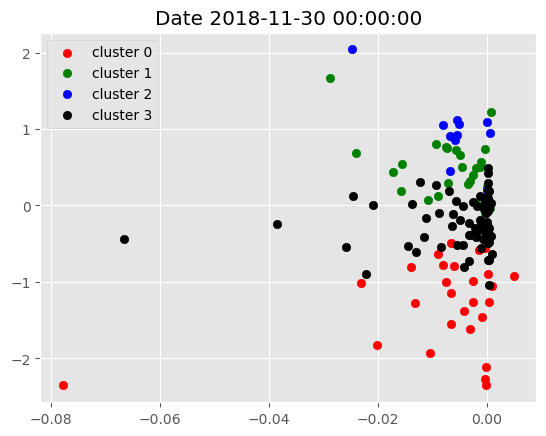

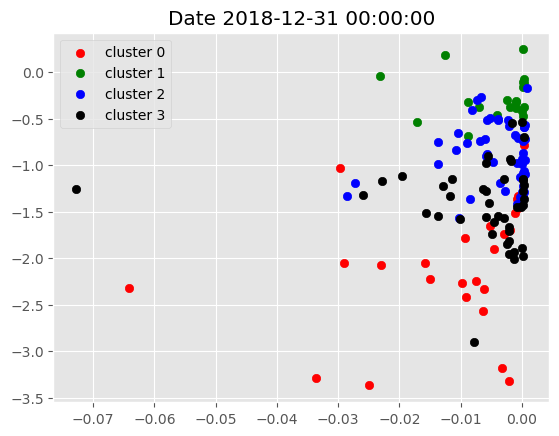

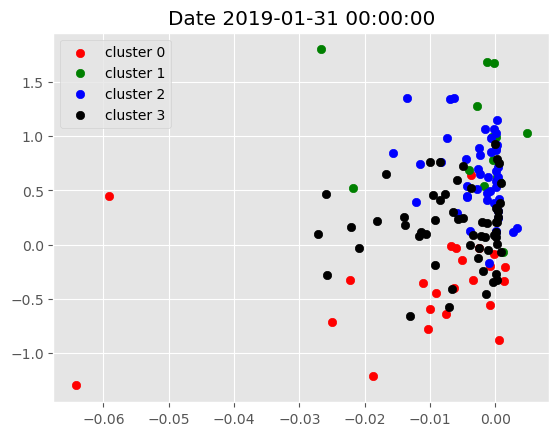

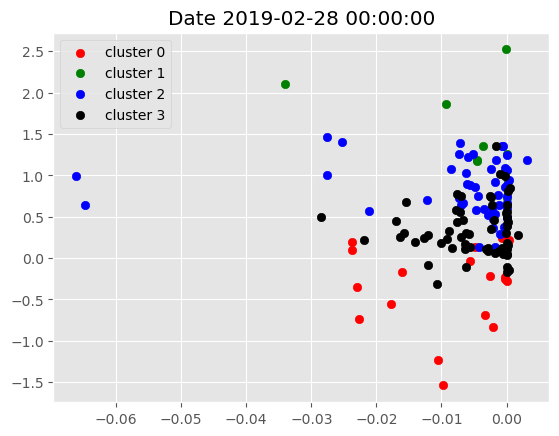

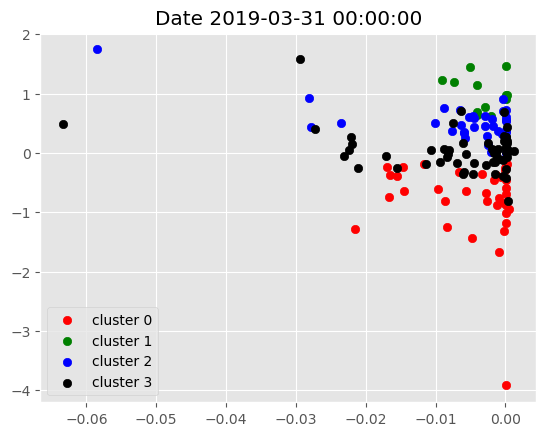

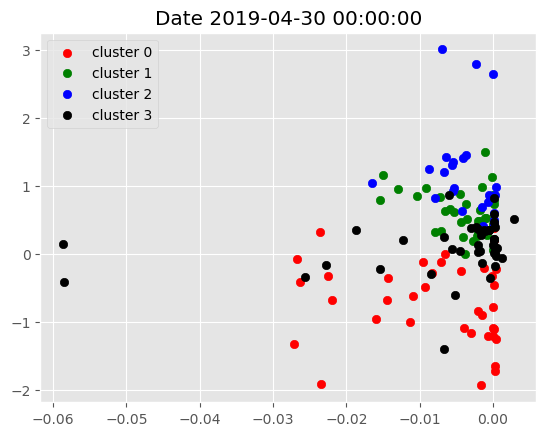

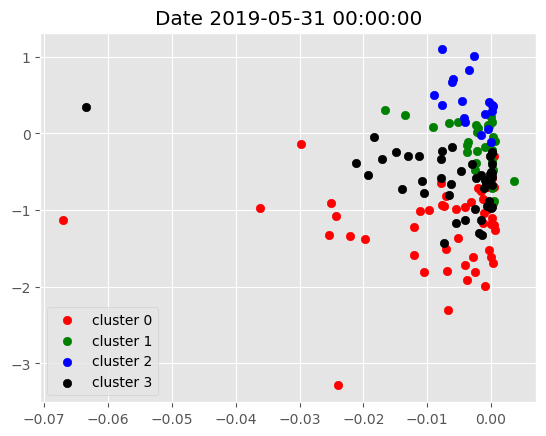

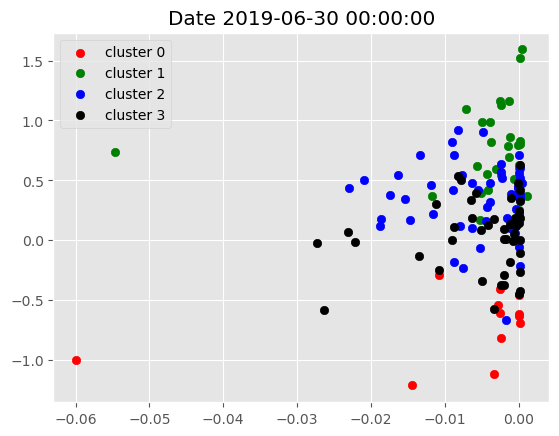

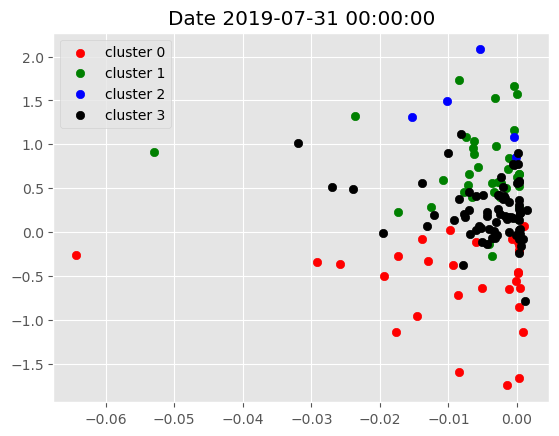

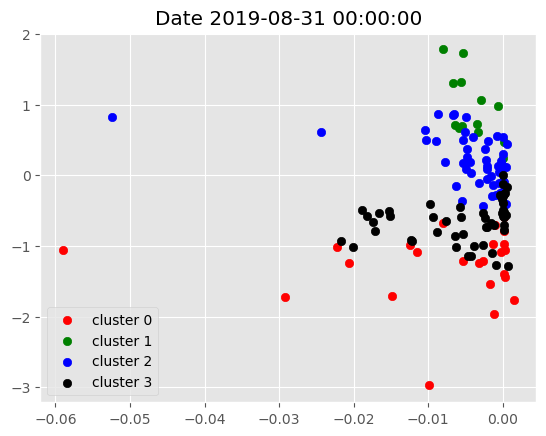

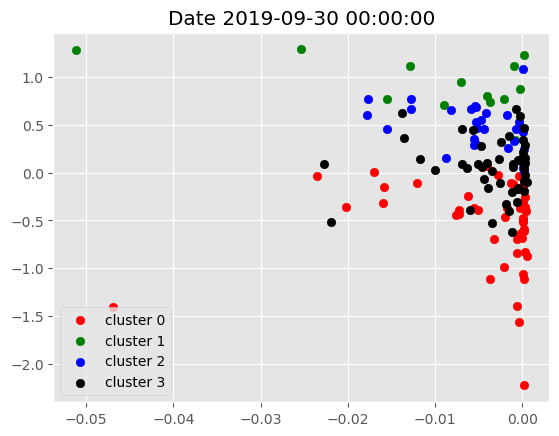

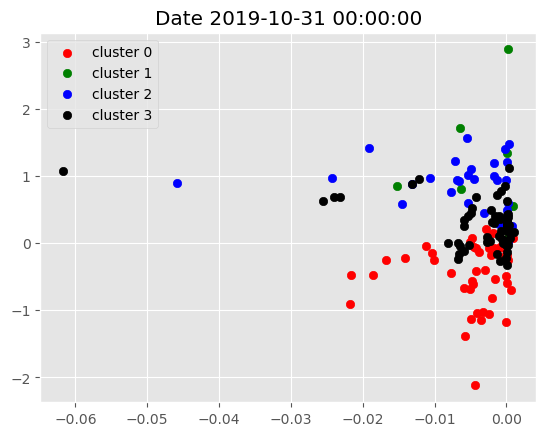

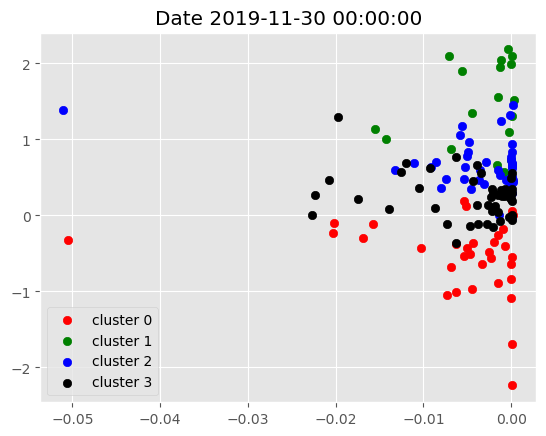

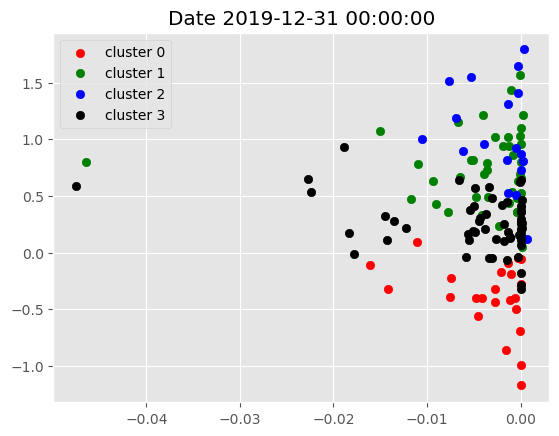

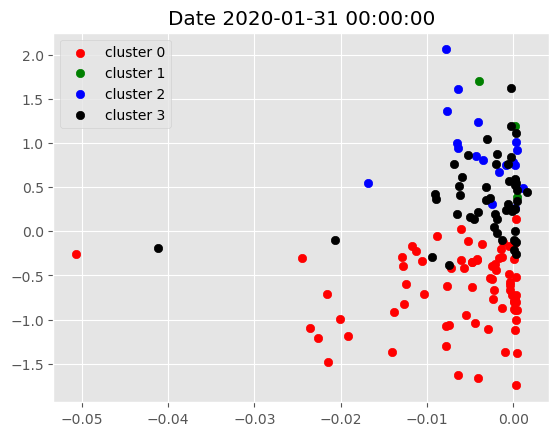

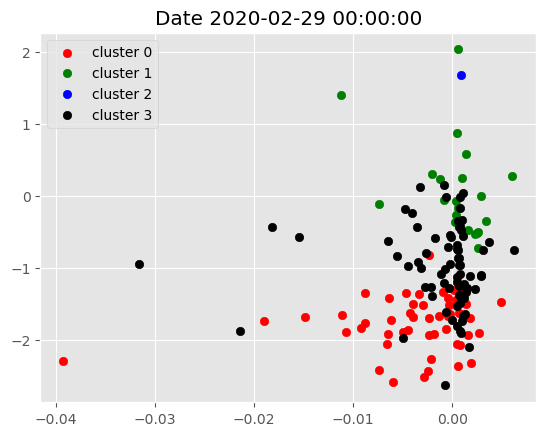

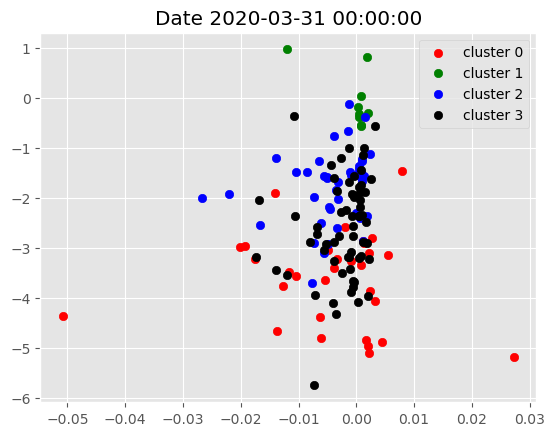

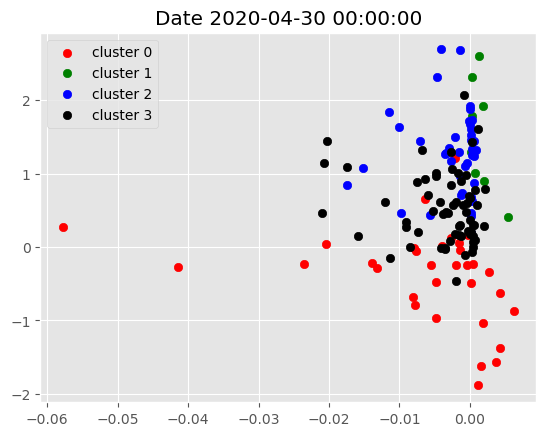

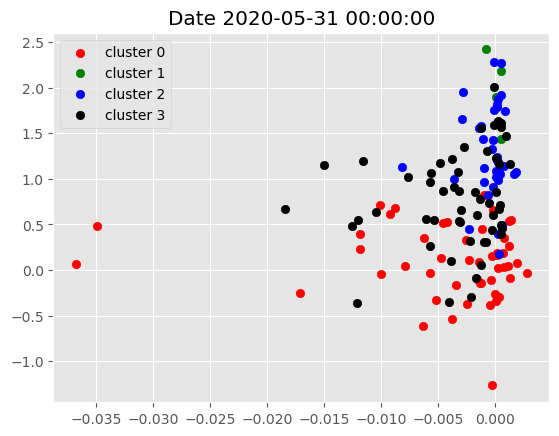

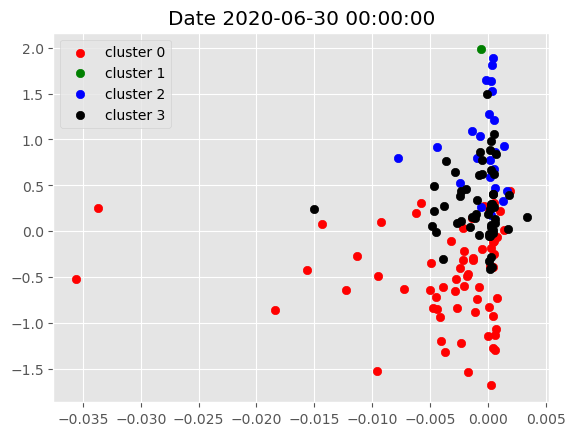

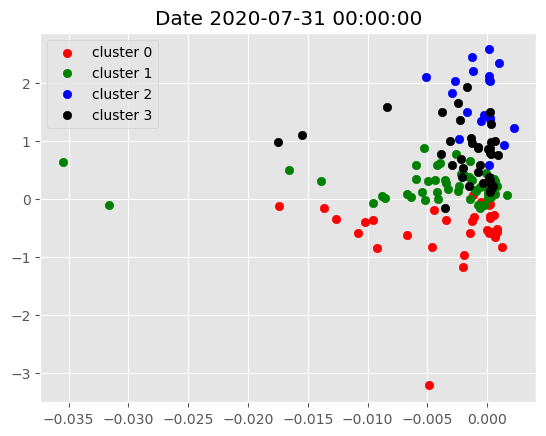

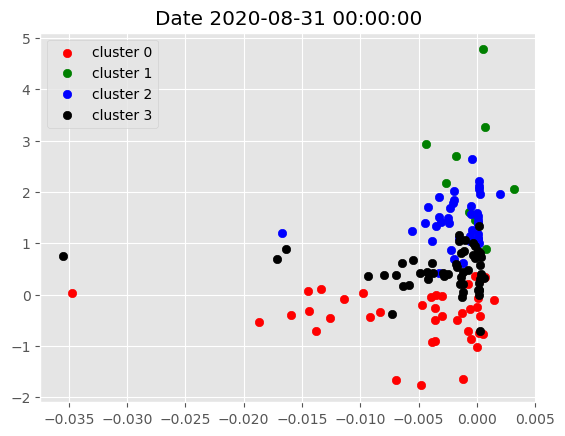

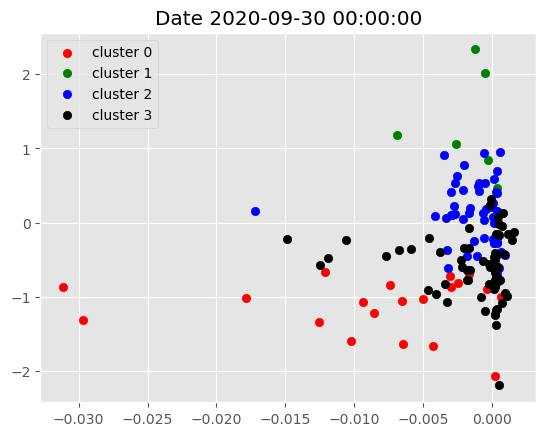

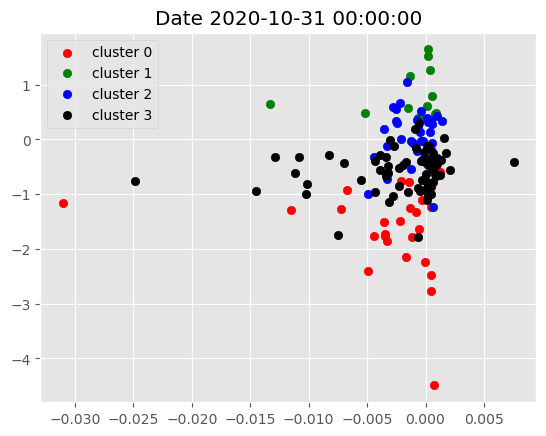

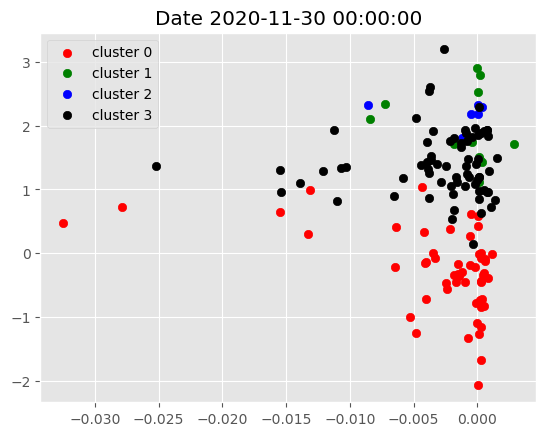

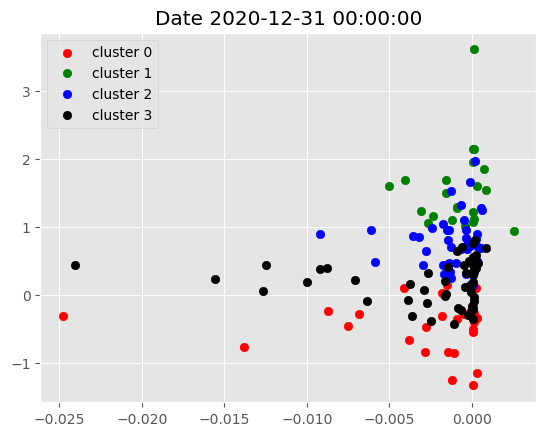

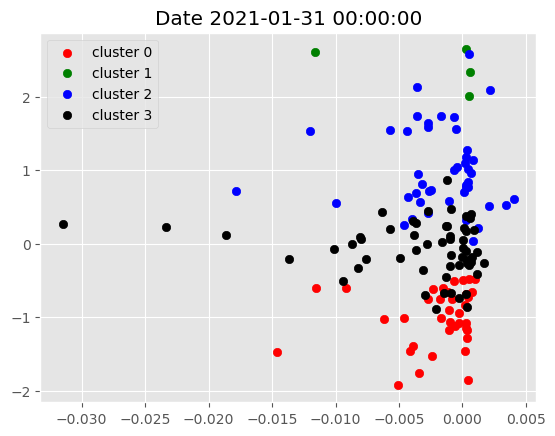

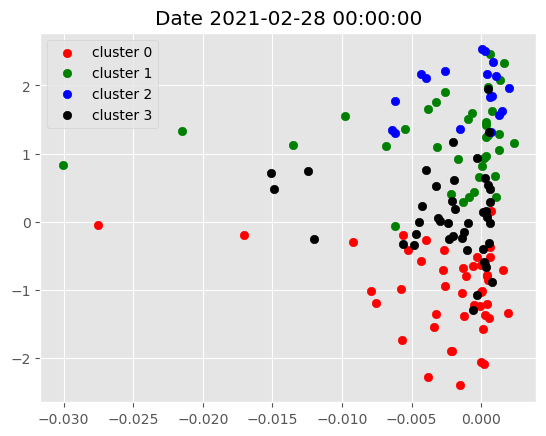

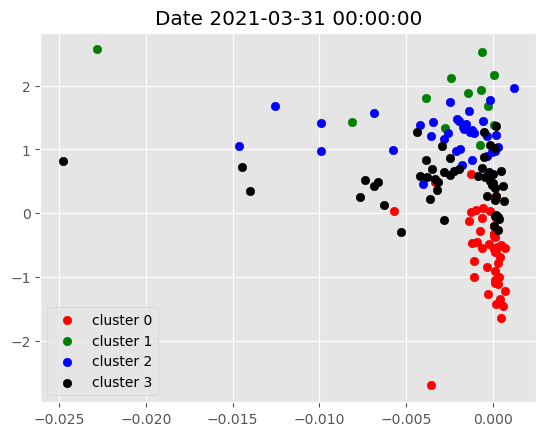

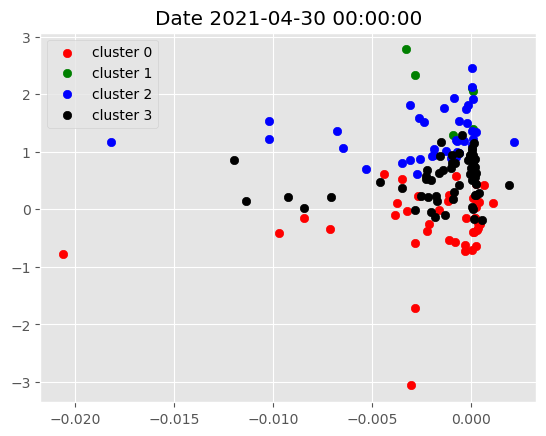

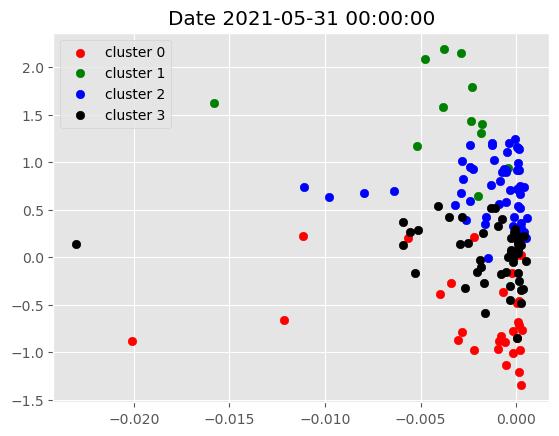

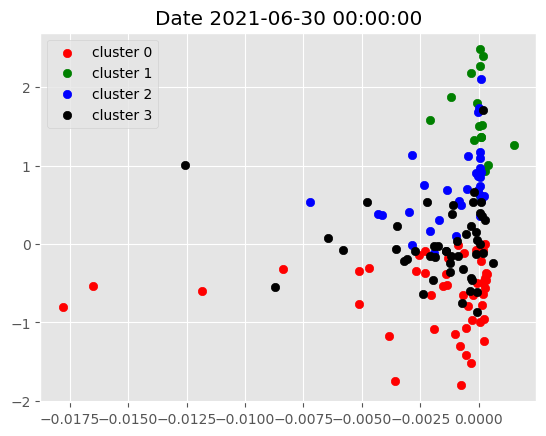

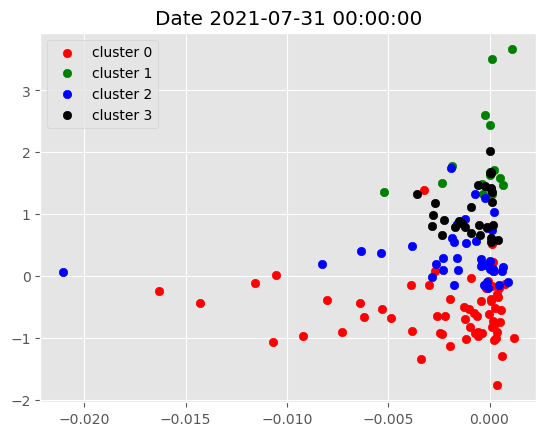

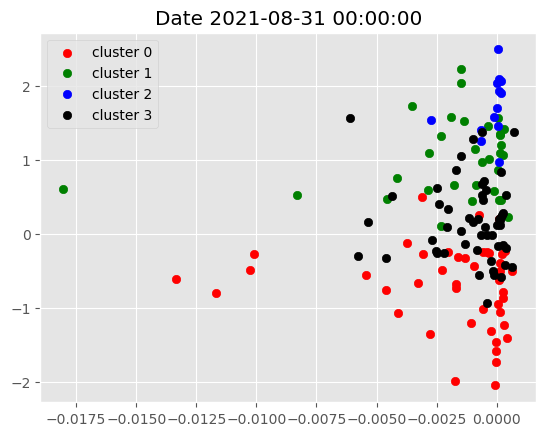

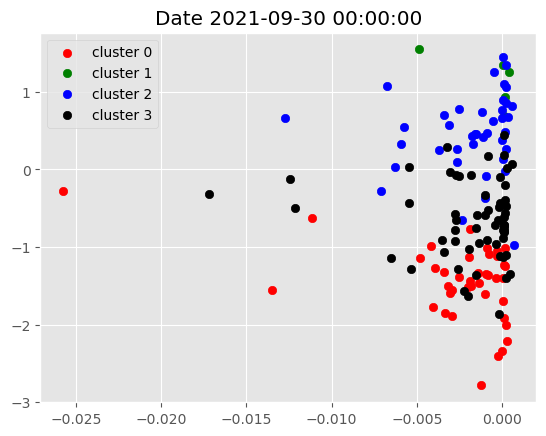

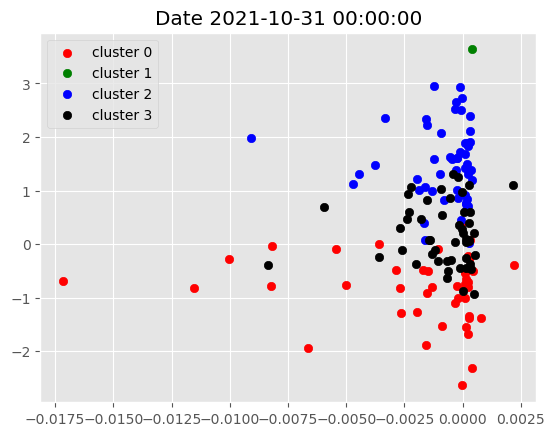

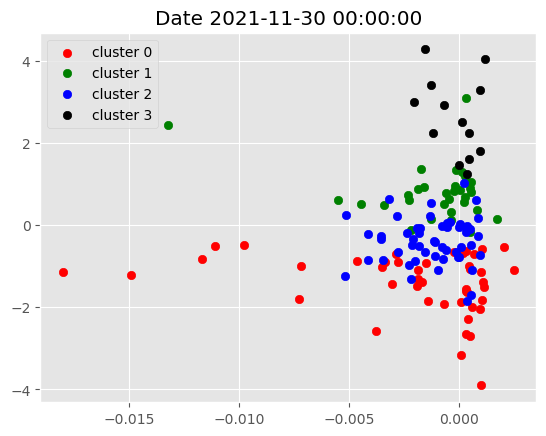

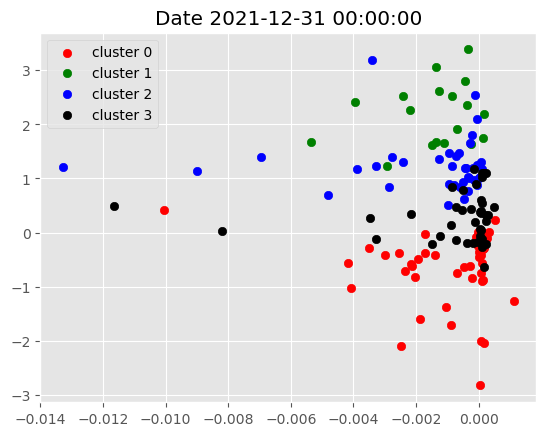

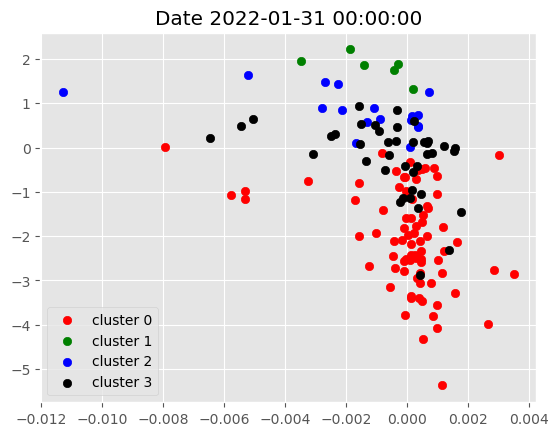

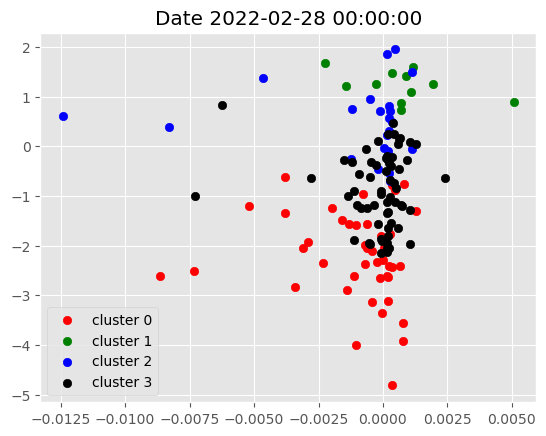

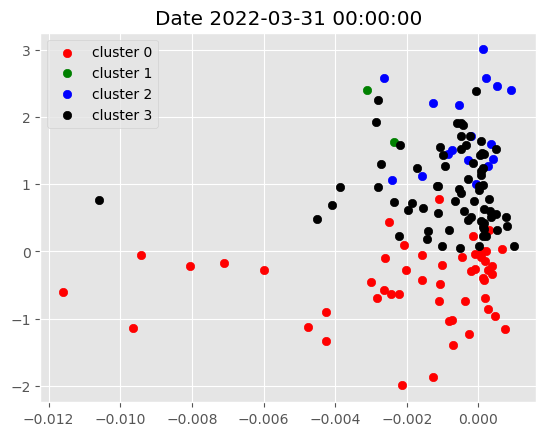

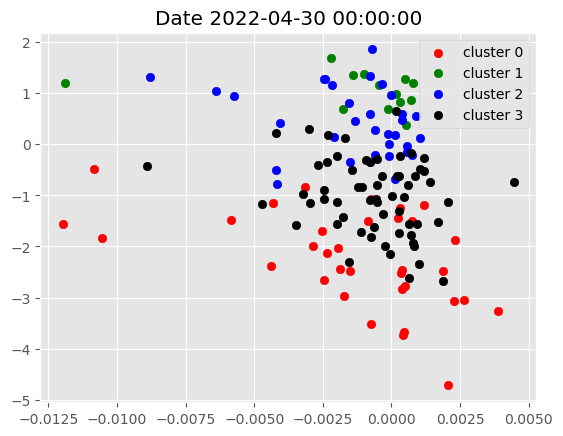

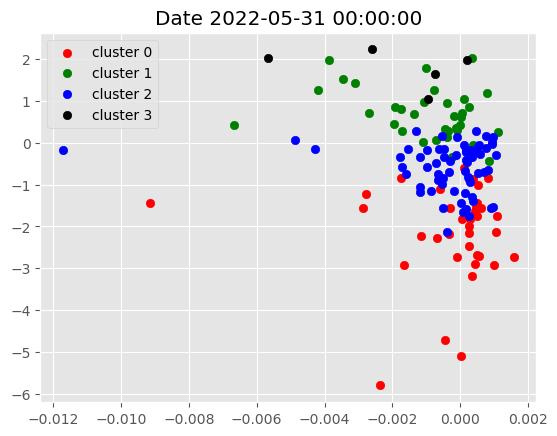

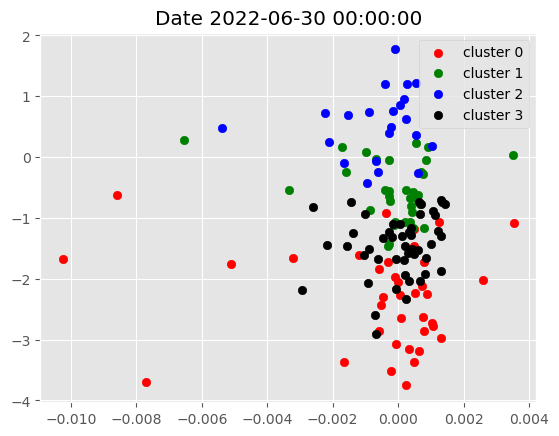

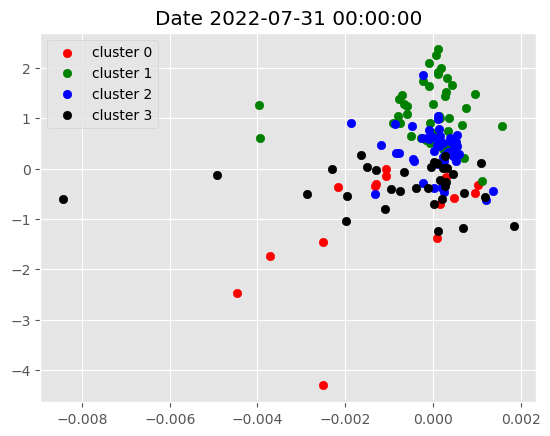

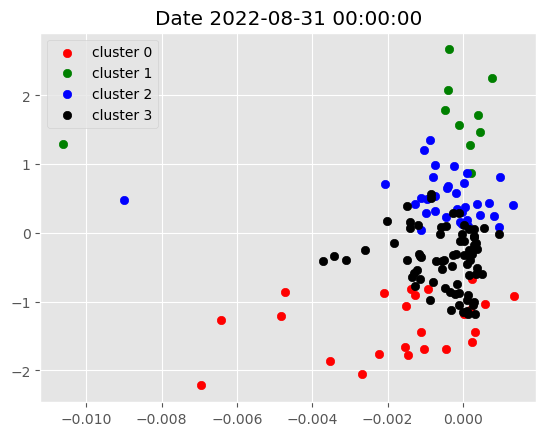

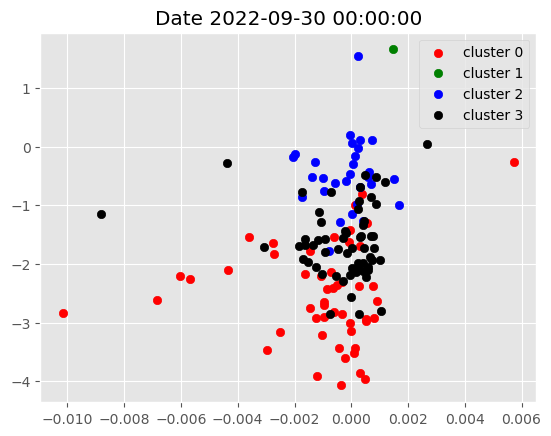

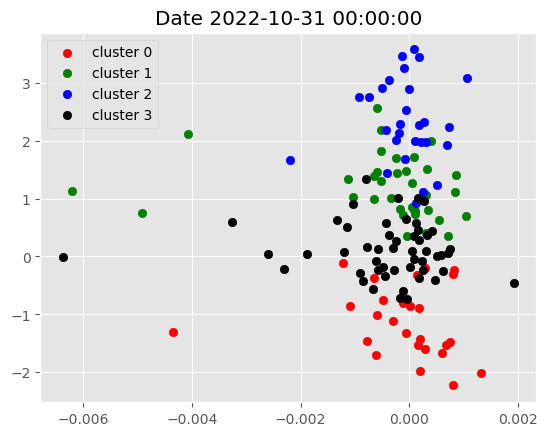

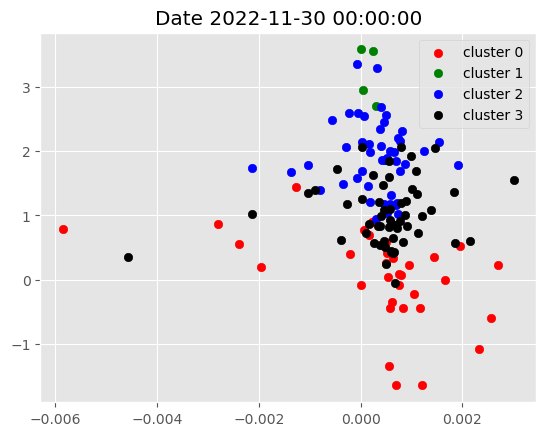

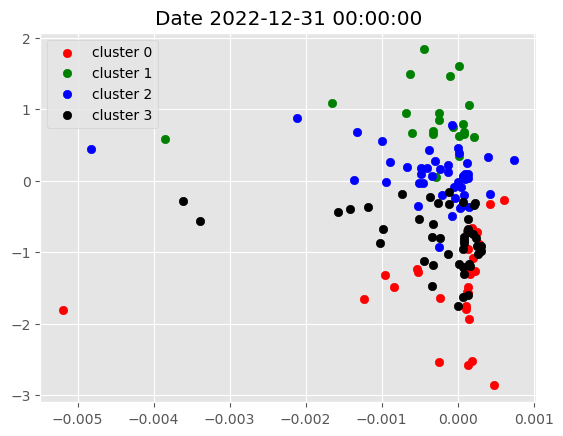

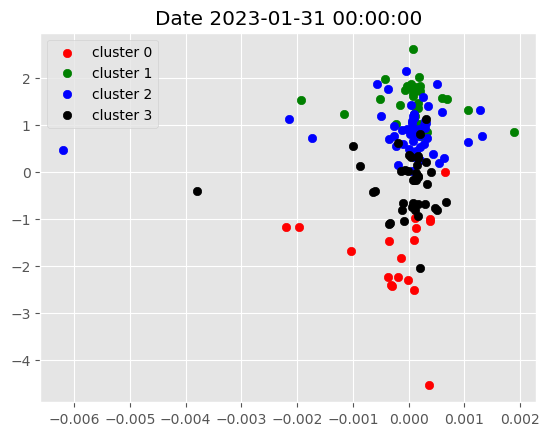

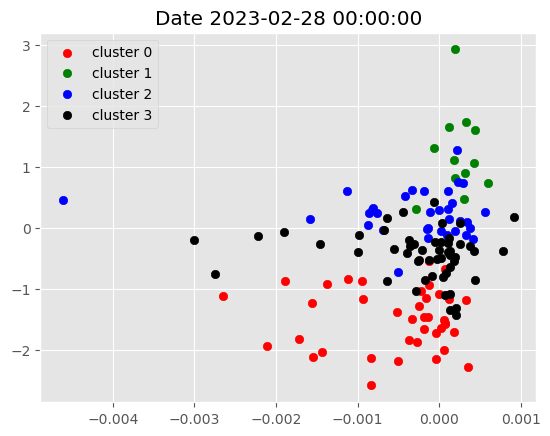

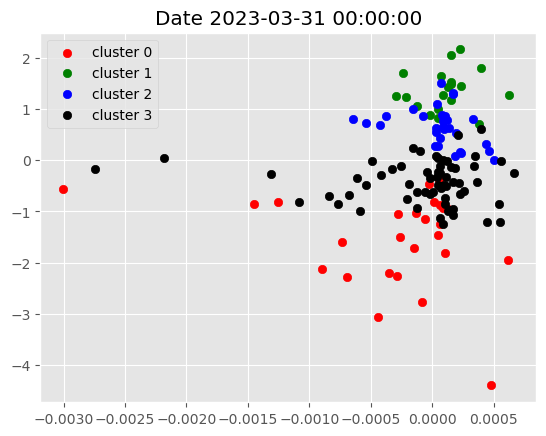

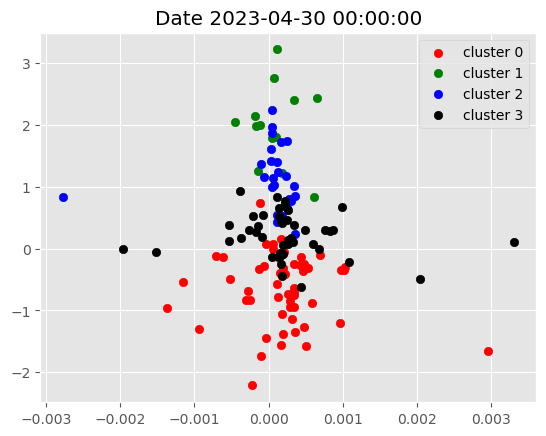

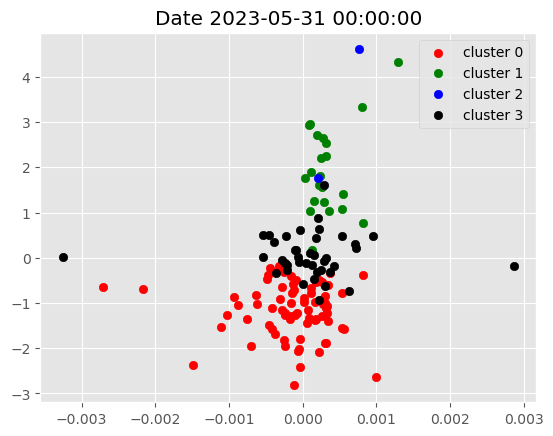

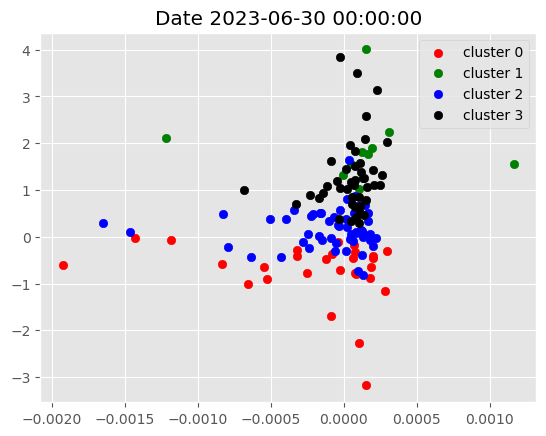

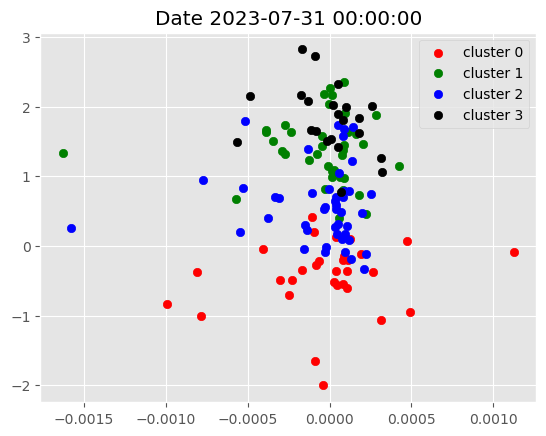

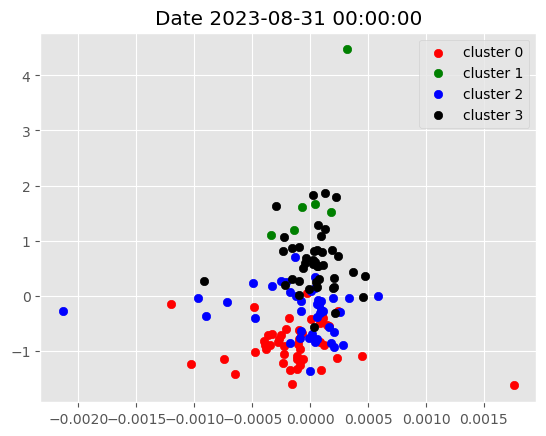

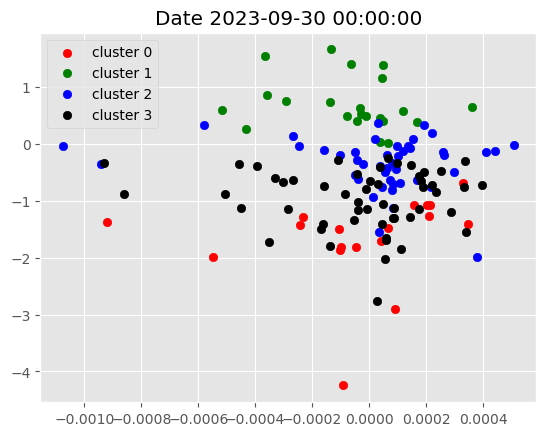

In [76]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    
    g = data.xs(i, level=0)
    
    plt.title(f'Date {i}')
    
    plot_clusters(g)

In [77]:
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 6] = target_rsi_values

initial_centroids

array([[ 0.,  0.,  0.,  0.,  0.,  0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

In [79]:
filtered_df = data[data['cluster']==3].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
    
fixed_dates

{'2017-11-01': ['ABBV',
  'ABT',
  'AZO',
  'BA',
  'BKNG',
  'BMY',
  'BRK-B',
  'C',
  'COST',
  'CVX',
  'DAL',
  'DG',
  'EA',
  'EBAY',
  'FDX',
  'GM',
  'GS',
  'HAL',
  'HON',
  'IBM',
  'ILMN',
  'JNJ',
  'KO',
  'KR',
  'LMT',
  'LOW',
  'MDLZ',
  'MDT',
  'MO',
  'MS',
  'NFLX',
  'NKE',
  'ORLY',
  'OXY',
  'PANW',
  'RTX',
  'SBUX',
  'SCHW',
  'TGT',
  'TMO',
  'UNP',
  'UPS',
  'USB',
  'VZ',
  'WDC',
  'WYNN'],
 '2017-12-01': ['AAPL',
  'AMGN',
  'BIIB',
  'BMY',
  'CCL',
  'CMCSA',
  'CMG',
  'COP',
  'CRM',
  'DD',
  'EOG',
  'GILD',
  'GM',
  'GOOG',
  'GOOGL',
  'JNJ',
  'KO',
  'LLY',
  'MA',
  'MCK',
  'MDT',
  'META',
  'NVDA',
  'ORCL',
  'PANW',
  'PG',
  'PYPL',
  'STZ',
  'TGT',
  'TMO',
  'TXN',
  'ULTA',
  'V',
  'WBA'],
 '2018-01-01': ['ABBV',
  'ADBE',
  'AMZN',
  'C',
  'CCL',
  'CHTR',
  'CMCSA',
  'CSX',
  'CVS',
  'DD',
  'DHR',
  'DIS',
  'EBAY',
  'ELV',
  'F',
  'GOOG',
  'GOOGL',
  'GS',
  'HON',
  'HUM',
  'IBM',
  'ILMN',
  'JNJ',
  'KO',
  'LMT

In [4]:
!pip install numpy --upgrade


     ---------------------------------------- 15.8/15.8 MB 1.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.4
    Uninstalling numpy-1.24.4:
      Successfully uninstalled numpy-1.24.4


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\ASUS\\anaconda3\\Lib\\site-packages\\~umpy\\.libs\\libopenblas64__v0.3.21-gcc_10_3_0.dll'
Consider using the `--user` option or check the permissions.



In [7]:
pip install PyPortfolioOpt

  Using cached pyportfolioopt-1.5.5-py3-none-any.whl (61 kB)
  Using cached cvxpy-1.5.1-cp39-cp39-win_amd64.whl (1.1 MB)
  Using cached scs-3.2.4.post2-cp39-cp39-win_amd64.whl (8.4 MB)
  Using cached clarabel-0.9.0-cp37-abi3-win_amd64.whl (736 kB)
  Using cached osqp-0.6.7-cp39-cp39-win_amd64.whl (292 kB)
  Using cached ecos-2.0.13-cp39-cp39-win_amd64.whl (72 kB)
  Using cached qdldl-0.1.7.post2-cp39-cp39-win_amd64.whl (86 kB)
Note: you may need to restart the kernel to use updated packages.


In [80]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, expected_returns


In [81]:
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):
    
    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)
    
    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)
    
    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')
    
    weights = ef.max_sharpe()
    
    return ef.clean_weights()

In [82]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1])

new_df

[*********************100%%**********************]  155 of 155 completed


Price       Adj Close                                                 \
Ticker            AAL        AAPL        ABBV        ABT         ACN   
Date                                                                   
2016-10-31  39.134327   26.212475   40.245121  34.293449  103.569595   
2016-11-01  38.363209   25.739202   40.728523  34.127403  103.480522   
2016-11-02  38.276451   25.762281   40.973835  33.821526  105.681297   
2016-11-03  38.054203   25.486147   40.324490  33.541874  104.202217   
2016-11-04  38.402084   25.256420   40.432709  34.162373  104.451721   
...               ...         ...         ...        ...         ...   
2023-09-25  12.910000  175.386337  150.264954  95.991318  313.318970   
2023-09-26  12.700000  171.282578  149.545944  94.770134  307.012848   
2023-09-27  12.610000  169.758591  148.788055  94.080750  310.739227   
2023-09-28  12.920000  170.017578  147.933014  96.631454  297.286835   
2023-09-29  12.810000  170.535538  144.833450  95.380722  303.553406   

Price                                                                  ...  \
Ticker            ADBE         ADP        ADSK        AIG        AMAT  ...   
Date                                                                   ...   
2016-10-31  107.510002   74.257103   72.279999  50.735882   26.606323  ...   
2016-11-01  106.870003   74.137695   70.099998  49.897144   26.441641  ...   
2016-11-02  105.889999   76.747704   68.680000  49.790249   26.158009  ...   
2016-11-03  107.169998   76.193321   67.610001  47.816727   25.865231  ...   
2016-11-04  106.199997   75.980064   69.440002  47.183559   25.819483  ...   
...                ...         ...         ...        ...         ...  ...   
2023-09-25  511.600006  237.203598  205.669998  61.502777  135.818924  ...   
2023-09-26  506.299988  234.456207  201.660004  60.641556  133.323090  ...   
2023-09-27  502.600006  239.782959  202.279999  60.394081  134.297577  ...   
2023-09-28  504.670013  240.454971  207.889999  60.661354  137.439713  ...   
2023-09-29  509.899994  237.757019  206.910004  59.988220  137.668427  ...   

Price         Volume                                                           \
Ticker             V      VLO     VRTX        VZ       WBA      WDC       WFC   
Date                                                                            
2016-10-31  10024000  4969500  1928200  12459400   4662100  3363200  20115900   
2016-11-01  10881500  7816800  2458200  13229400   5130800  3821100  20020200   
2016-11-02   9170900  7317600  2580400  16488200   9783100  4216200  19566600   
2016-11-03   7563100  3855900  2371000  12605100   4586500  3192600  14982700   
2016-11-04   7588100  3729900  1902100  14410200   7023900  2705600  27391600   
...              ...      ...      ...       ...       ...      ...       ...   
2023-09-25   5921600  3241900   698100  17616900   6891000  2685900  10624000   
2023-09-26   6193200  4936800   633600  18841600   7570500  3571100  15219400   
2023-09-27   6006700  3644000   860600  22083500  10182900  2547800  11815500   
2023-09-28   4203900  3587300   578900  18772100   7291500  3282000  12454600   
2023-09-29   6044200  4302200   896800  19759400  25659100  2512000  13119100   

Price                                    
Ticker           WMT     WYNN       XOM  
Date                                     
2016-10-31  19167000  1341600  16663800  
2016-11-01  26515800  3722300  13050600  
2016-11-02  22935900  2542400  11226100  
2016-11-03  20411700  9050400   8836500  
2016-11-04  21786300  3223800  13877100  
...              ...      ...       ...  
2023-09-25  10459500  1387800  11316000  
2023-09-26  14435700  1454000  11805400  
2023-09-27  15711000  2050000  23976200  
2023-09-28  11617200  1290400  16808100  
2023-09-29  18842400  1326800  18810700  

[1740 rows x 930 columns]

In [84]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    
    try:

        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')

        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        
        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]
        
        success = False
        try:
            weights = optimize_weights(prices=optimization_df,
                                   lower_bound=round(1/(len(optimization_df.columns)*2),3))

            weights = pd.DataFrame(weights, index=pd.Series(0))
            
            success = True
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')
        
        if success==False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index=optimization_df.columns.tolist(),
                                     columns=pd.Series(0)).T
        
            temp_df = returns_dataframe[start_date:end_date]

            temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                   .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                          left_index=True,
                          right_index=True)\
                   .reset_index().set_index(['Date', 'index']).unstack().stack()

            temp_df.index.names = ['date', 'ticker']

            temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

            temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

            portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)

SyntaxError: unexpected EOF while parsing (424625396.py, line 49)

In [94]:

returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    try:
        end_date = (pd.to_datetime(start_date) + pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')
        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date) - pd.DateOffset(months=12)).strftime('%Y-%m-%d')
        optimization_end_date = (pd.to_datetime(start_date) - pd.DateOffset(days=1)).strftime('%Y-%m-%d')

        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]

        success = False
        try:
            weights = optimize_weights(prices=optimization_df,
                                       lower_bound=round(1 / (len(optimization_df.columns) * 2), 3))
            weights = pd.DataFrame(weights, index=pd.Series(0))
            success = True
        except Exception as e:
            print(f"Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights. Error: {e}")

        if not success:
            weights = pd.DataFrame([1 / len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                   index=optimization_df.columns.tolist(),
                                   columns=pd.Series(0)).T

        temp_df = returns_dataframe[start_date:end_date]

        temp_df = temp_df.stack().to_frame('return').reset_index(level=0) \
            .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                   left_index=True,
                   right_index=True) \
            .reset_index().set_index(['Date', 'Ticker']).unstack().stack()

        temp_df.index.names = ['date', 'ticker']

        temp_df['weighted_return'] = temp_df['return'] * temp_df['weight']

        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)

    except Exception as e:
        print(f"Error processing start_date {start_date}: {e}")

# Verify the final portfolio_df
print(portfolio_df.head())


Max Sharpe Optimization failed for 2022-06-01, Continuing with Equal-Weights. Error: ('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')
Error processing start_date 2023-10-01: 'return'
            Strategy Return
date                       
2017-11-01         0.001420
2017-11-02         0.001687
2017-11-03         0.002936
2017-11-06        -0.000732
2017-11-07        -0.001691


In [95]:
spy = yf.download(tickers='SPY',
                  start='2015-01-01',
                  end=dt.date.today())

spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close':'SPY Buy&Hold'}, axis=1)

portfolio_df = portfolio_df.merge(spy_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

[*********************100%%**********************]  1 of 1 completed


,Strategy Return,SPY Buy&Hold
2017-11-01,0.001420,0.001321
2017-11-02,0.001687,0.000388
2017-11-03,0.002936,0.003333
2017-11-06,-0.000732,0.001547
2017-11-07,-0.001691,-0.000696
...,...,...
2023-09-25,0.005667,0.004196
2023-09-26,-0.015110,-0.014800
2023-09-27,0.005975,0.000399
2023-09-28,0.009038,0.005781


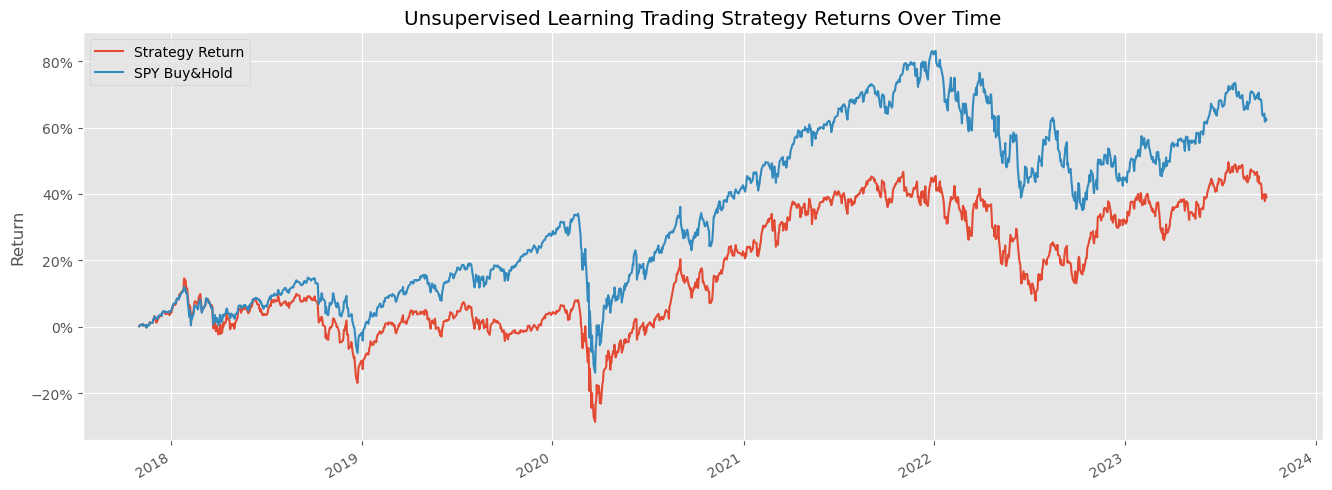

In [96]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return[:'2023-09-29'].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()